[@ggruszczynski](https://github.com/ggruszczynski)

In [2]:
from sympy import fourier_transform, exp, sqrt, pi, cos, simplify
from sympy.abc import x, k, t, symbols
from sympy import init_printing
init_printing(use_unicode=False, wrap_line=False)

import timeit
import numpy as np
import matplotlib.pyplot as plt

Diffusion part 2: matrix approach; implicit and explicit scheme 
-----
***

The one-dimensional diffusion equation is:

$$\frac{\partial u}{\partial t}= \nu \frac{\partial^2 u}{\partial x^2}$$

The first thing you should notice is that —unlike the previous two simple equations we have studied— this equation has a second-order derivative. We first need to learn what to do with it!

### Discretizing $\frac{\partial ^2 u}{\partial x^2}$

The second-order derivative can be represented geometrically as the line tangent to the curve given by the first derivative.  We will discretize the second-order derivative with a Central Difference scheme: a combination of Forward Difference and Backward Difference of the first derivative.  Consider the Taylor expansion of $u_{i+1}$ and $u_{i-1}$ around $u_i$:

$u_{i+1} = u_i + \Delta x \frac{\partial u}{\partial x}\bigg|_i + \frac{\Delta x^2}{2} \frac{\partial ^2 u}{\partial x^2}\bigg|_i + \frac{\Delta x^3}{3!} \frac{\partial ^3 u}{\partial x^3}\bigg|_i + O(\Delta x^4)$

$u_{i-1} = u_i - \Delta x \frac{\partial u}{\partial x}\bigg|_i + \frac{\Delta x^2}{2} \frac{\partial ^2 u}{\partial x^2}\bigg|_i - \frac{\Delta x^3}{3!} \frac{\partial ^3 u}{\partial x^3}\bigg|_i + O(\Delta x^4)$

If we add these two expansions, you can see that the odd-numbered derivative terms will cancel each other out.  If we neglect any terms of $O(\Delta x^4)$ or higher (and really, those are very small), then we can rearrange the sum of these two expansions to solve for our second-derivative.  


$u_{i+1} + u_{i-1} = 2u_i+\Delta x^2 \frac{\partial ^2 u}{\partial x^2}\bigg|_i + O(\Delta x^4)$

Then rearrange to solve for $\frac{\partial ^2 u}{\partial x^2}\bigg|_i$ and the result is:

$$\frac{\partial ^2 u}{\partial x^2}=\frac{u_{i+1}-2u_{i}+u_{i-1}}{\Delta x^2} + O(\Delta x^4)$$


### Back to Step 3

We can now write the discretized version of the diffusion equation in 1D:

$$\frac{u_{i}^{n+1}-u_{i}^{n}}{\Delta t}=\nu\frac{u_{i+1}^{n}-2u_{i}^{n}+u_{i-1}^{n}}{\Delta x^2}$$

As before, we notice that once we have an initial condition, the only unknown is $u_{i}^{n+1}$, so we re-arrange the equation solving for our unknown:

$$u_{i}^{n+1}=u_{i}^{n}+\underbrace{\frac{\nu\Delta t}{\Delta x^2}}_{\beta}(u_{i+1}^{n}-2u_{i}^{n}+u_{i-1}^{n})$$


$$u_{i}^{n+1}=\beta u_{i-1}^{n} + u_{i}^{n}(1- 2 \beta) +\beta u_{i+1}^{n}$$

The above discrete equation allows us to write a program to advance a solution in time. But we need an initial condition. Let's continue using our favorite: the hat function. So, at $t=0$, $u=2$ in the interval $0.5\le x\le 1$ and $u=1$ everywhere else. We are ready to number-crunch!

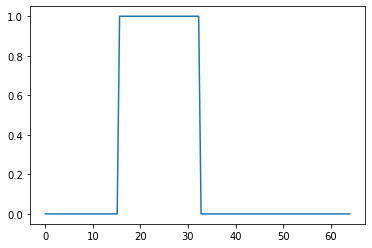

In [2]:
# %matplotlib inline

nx = 128
domain_length = 64
dx = domain_length / (nx-1)
xspace = np.linspace(0, domain_length, nx)

nt = 200                # the number of timesteps we want to calculate
nu = 5                  # the value of viscosity
sigma = .2              # sigma is a parameter, we'll learn more about it later
dt = sigma * dx**2 / nu # dt is defined using sigma ... more later!

u_IC = 0*np.ones(nx)                 # numpy function ones()
u_IC[int((nx-1)/4):int(nx/2 + 1)] = 1 # setting u = 2 between 0.5 and 1 as per our I.C.s

plt.plot(xspace, u_IC)

# Matrix approach

## Explicit, central FD - matrix approach


Notice, that the scheme 

$$u_{i}^{n+1}=\beta u_{i-1}^{n} + u_{i}^{n}(1- 2 \beta) +\beta u_{i+1}^{n}$$

where $\beta = \frac{\nu\Delta t}{\Delta x^2}$ can be formulated as:

$$
\boldsymbol{u}^{n+1} = \mathbb{A} \boldsymbol{u}^n 
$$


Observe, that $ \mathbb{A} $ have a tridiagonal structure:

$$
\begin{bmatrix} 
A_{0,0} & A_{0,1} & A_{0,2} & \\
\beta  & 1 - 2 \beta& \beta \\
0 & \beta  & 1- 2 \beta & \beta \\
0 & 0 & \beta & 1- 2 \beta & \beta \\
... \\
... \\
... \\
0 & 0 & 0 & 0 & 0 & \beta & 1- 2 \beta & \beta \\
0 & 0 & 0 & 0 & 0 & A_{n,n-2} & A_{n,n-1}  & A_{n,n}\\
\end{bmatrix}
\quad
$$

**Hint:**

Fill the corners of the matrix using asymmetric stencils:

* forward FD for $A_{0,0}, A_{0,1}$ and $A_{0,2}$

$$\frac{u_{i}^{n+1}-u_{i}^{n}}{\Delta t}=\nu\frac{u_i^{n}  -2u_{i+1}^{n} + u_{i+2}^{n}}{\Delta x^2}$$

$$u_{i}^{n+1} = (1 + \beta ) u_{i}^{n} - 2\beta u_{i+1}^{n} + \beta u_{i+2}^{n} $$


* backward FD for $A_{n,n}, A_{n,n-1}$ and $A_{n,n-2}$

$$\frac{u_{i}^{n+1}-u_{i}^{n}}{\Delta t}=\nu\frac{u_i^{n}  -2u_{i-1}^{n} + u_{i-2}^{n}}{\Delta x^2}$$

$$u_{i}^{n+1} = (1 + \beta ) u_{i}^{n} - 2\beta u_{i-1}^{n} + \beta u_{i-2}^{n} $$


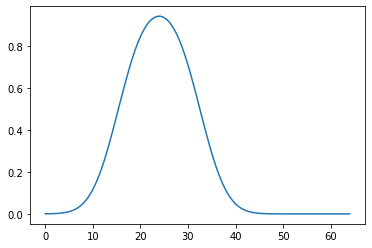

In [8]:
# explicit central FD
import numpy as np
np.set_printoptions(precision=3, suppress=True)

un_ecfd = u_IC.copy()

A = np.zeros((nx, nx))
                
Beta_FD = dt * nu / (dx**2) 
last_index_in_matrix = nx -1 

# the BC  - use one sided FD            
A[0, 0] = # TODO...   # forward FD
A[0, 1] = # TODO...   # forward FD
A[0, 2] = # TODO...   # forward FD
A[last_index_in_matrix, last_index_in_matrix-2] = # TODO...  # backward FD
A[last_index_in_matrix, last_index_in_matrix-1] = # TODO...  # backward FD
A[last_index_in_matrix, last_index_in_matrix] =   # TODO...   # backward FD
for i in range(1, last_index_in_matrix): 
    A[i, i-1] = # TODO...       # left of the diagonal
    A[i, i] =   # TODO...       # the diagonal
    A[i, i+1] = # TODO...       # right of the diagonal   


# print(f"determinant A_inv: {np.linalg.det(A_inv)}") 
w, v = np.linalg.eig(A_inv)
print(f"max(abs(eigenvalues): {np.max(np.abs(w)):.20e}") 
# plt.plot(np.abs(w))  # plot the eigenvalues


for n in range(nt):  #loop for values of n from 0 to nt, so it will run nt times
    un_ecfd = A@un_ecfd
    # un_ecfd = np.dot(A,un_ecfd) # alternative way of doing the same

#plt.plot(xspace, un_ecfd)


## Implicit, central FD

The laplace operator is calculated using values from the future ($u^{n+1}$).

$$\frac{u_{i}^{n+1}-u_{i}^{n}}{\Delta t}=\nu\frac{u_{i+1}^{n+1}-2u_{i}^{n+1}+u_{i-1}^{n+1}}{\Delta x^2}$$

$$u_{i}^{n+1}=u_{i}^{n}+\underbrace{\frac{\nu\Delta t}{\Delta x^2}}_{\beta}(u_{i+1}^{n+1}-2u_{i}^{n+1}+u_{i-1}^{n+1})$$

$$
-\beta u_{i-1}^{n+1} + (1+2 \beta)u_{i}^{n+1} - \beta u_{i+1}^{n+1} = u_{i}^{n}
$$

Notice, that the scheme can be formulated as:

$$
 \mathbb{A}  \boldsymbol{u}^{n+1} =\boldsymbol{u}^n 
$$


Observe, that $ \mathbb{A} $ have a tridiagonal structure:

$$
\begin{bmatrix} 
A_{0,0} & A_{0,1} & A_{0,2} & \\
-\beta  & 1+2 \beta & -\beta \\
0 & -\beta  & 1+2 \beta & -\beta \\
0 & 0 &- \beta & 1+2 \beta & -\beta \\
... \\
... \\
... \\
0 & 0 & 0 & 0 & 0 & -\beta & 1+2 \beta & -\beta \\
0 & 0 & 0 & 0 & 0 & A_{n,n-2} & A_{n,n-1}  & A_{n,n}\\
\end{bmatrix}
\quad
$$

**Hint:**

Fill the corners of the matrix using asymmetric stencils:
* forward FD for $A_{0,0}, A_{0,1}$ and $A_{0,2}$

$$\frac{u_{i}^{n+1}-u_{i}^{n}}{\Delta t}=\nu\frac{u_i^{n+1}  -2u_{i+1}^{n+1} + u_{i+2}^{n+1}}{\Delta x^2}$$

$$u_{i}^{n+1} (1-  \underbrace{\nu\frac{\Delta}{\Delta x^2}}_{\beta} ) + 2 \beta u_{i+1}^{n+1} - \beta u_{i+2}^{n+1} = u_{i}^{n} $$


* backward FD for $A_{n,n}, A_{n,n-1}$ and $A_{n,n-2}$

$$\frac{u_{i}^{n+1}-u_{i}^{n}}{\Delta t}=\nu\frac{u_i^{n+1}  -2u_{i-1}^{n+1} + u_{i-2}^{n+1}}{\Delta x^2}$$

$$u_{i}^{n+1} (1-  \underbrace{\nu\frac{\Delta}{\Delta x^2}}_{\beta} ) + 2 \beta u_{i-1}^{n+1} - \beta u_{i-2}^{n+1} = u_{i}^{n} $$


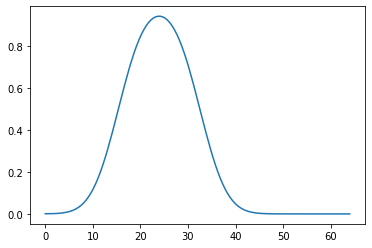

In [10]:
# implicit central FD
import numpy as np
np.set_printoptions(precision=3, suppress=True)

un_icfd = u_IC.copy()
A = np.zeros((nx, nx))
                
Beta_FD = dt * nu / (dx**2) 
# nt += 100
last_index_in_matrix = nx -1 
# the BC  - use one sided FD            
A[0, 0] = # TODO...   # forward FD
A[0, 1] = # TODO...   # forward FD
A[0, 2] = # TODO...   # forward FD
A[last_index_in_matrix, last_index_in_matrix-2] = # TODO...  # backward FD 
A[last_index_in_matrix, last_index_in_matrix-1] = # TODO...  # backward FD
A[last_index_in_matrix, last_index_in_matrix] =   # TODO...  # backward FD 
for i in range(1, last_index_in_matrix): 
    A[i, i-1] = # TODO...        # left of the diagonal
    A[i, i] =   # TODO...        # the diagonal
    A[i, i+1] = # TODO...        # right of the diagonal   

A_inv = np.linalg.inv(A)

# print(f"determinant A_inv: {np.linalg.det(A_inv)}") 
w, v = np.linalg.eig(A_inv)
print(f"max(abs(eigenvalues): {np.max(np.abs(w)):.20e}") 
# plt.plot(np.abs(w))  # plot the eigenvalues

for n in range(nt):  #loop for values of n from 0 to nt, so it will run nt times
    un_icfd = A_inv@un_icfd
    # alternative way of doing the same:
    #     un_icfd = np.dot(A_inv,un_icfd)
    #     b = un_icfd.copy() 
    #     un_icfd = np.linalg.solve(A, b) # u(t+1)
                
#plt.plot(xspace, un_icfd)

### Compare both schemes

Benchmark them using different values of the sigma parameter (set in the cell with initial conditions)
```
sigma = 0.2 
# or
sigma = .504 
```

In [ ]:
plt.rcParams.update({'font.size': 16})
figure, axis = plt.subplots(1, 1, figsize=(10, 8))
plt.subplots_adjust(hspace=1)
plt.plot(xspace, un_ecfd, label=r'$u_{ecfd}$', marker='x', linestyle="", markevery=2)
plt.plot(xspace, un_icfd, label=r'$u_{icfd}$')
axis.legend(loc="upper right")
plt.grid()

## Numerical precision

For the implicit scheme, the `max(abs(eigenvalues)`, is just slightly higher than 1, precisely 1.00000000000002375877e+00
 
There 13 zeros between 1 and the next decimal digit, so it is close to the limits of numerical precision for the double data type.

Can we go further?

In [ ]:
# Mpmath is a Python library for arbitrary-precision floating-point arithmetic. 
# For general information about mpmath, see the project website http://mpmath.org/
from mpmath import mp
print(mp)
mp.prec = 120  # denotes the binary precision (measured in bits)
# mp.dps = 29 # dps (short for decimal places) is the decimal precision. 
# Binary and decimal precision are related roughly according to the formula prec = 3.33*dps
print(mp)

In [ ]:
mpA = mp.matrix(A) # convert to mpmath format 
mpA_inv = mpA**-1  # inverse

In [ ]:
E, ER = mp.eig(mp.matrix(mpA_inv))  # E contains the eigenvalues of A. The columns of ER contain the right eigenvectors of A
E

In [ ]:
# TODO:
# print(f"max(abs(eigenvalues): {...get the max abs from E....}") 